# Intersession (MyoPanda)

## Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from read_emg import *
from build_CNN import *

plt.style.use('seaborn-bright')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Read the dataset (Discrete Task)

In [2]:
df = read_file()

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:26<00:00,  4.92it/s]


In [3]:
df.head()

,timestamp,kf1,kf2,kf3,kf4,kf5,kf6,kf7,kf8,ID,session,task,Trial_num,target_position,trialState
0,1134.897949,1.510638,1.797154,2.008409,3.027455,5.645501,5.708248,1.951315,1.322882,1614,0,0,1,720.0,1
1,1134.919556,1.517236,1.793619,1.982876,3.007721,5.646880,5.604728,1.917896,1.322608,1614,0,0,1,720.0,1
2,1134.930664,1.523206,1.790421,1.959773,2.989864,5.648128,5.511056,1.887657,1.322360,1614,0,0,1,720.0,1
3,1134.947876,1.528609,1.787527,1.938867,2.973706,5.649258,5.426294,1.860293,1.322135,1614,0,0,1,720.0,1
4,1134.965210,1.533497,1.792519,1.933267,2.970499,5.739697,5.307741,1.824118,1.333347,1614,0,0,1,720.0,1


## Visualization of trial state and the EMG in discrete task

In order to apply supervised learning, we have to label the EMG signal first. 

The quick and dirty way is to set trial_state 3 (Cyan) as Wrist extension, and 1 and 2 as Rest (Pink and green)

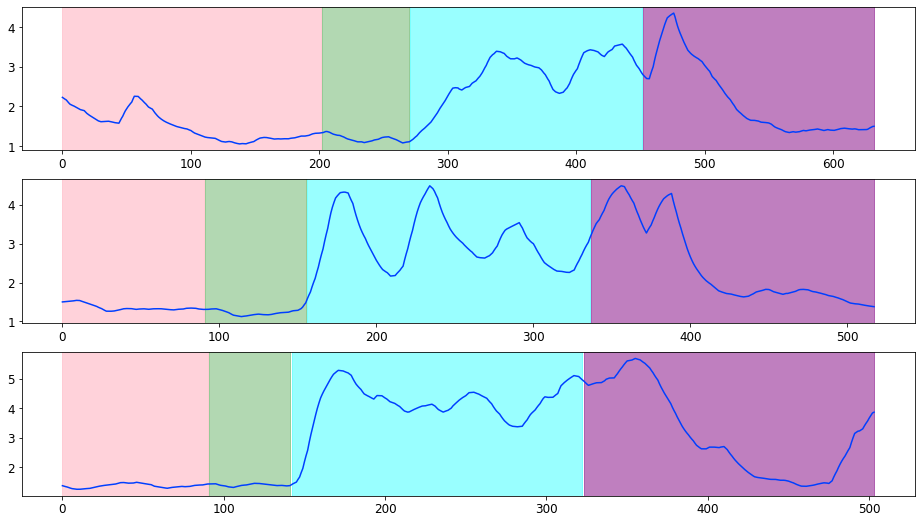

In [4]:
fig, ax = plt.subplots(3, figsize = (16, 9))
count = 0
for trial_num in range(1, 4):
    df_for_plot = df[(df['Trial_num'] == trial_num) & (df['session'] == 5) & (df['ID'] == '1614') & (df['task'] == 0)]
    if len(df_for_plot) == 0:
        continue
        
    df_for_plot['kf4'].plot(ax = ax[count])
    idx_st1 = df_for_plot[df_for_plot['trialState'] == 1].index
    idx_st2 = df_for_plot[df_for_plot['trialState'] == 2].index
    idx_st3 = df_for_plot[df_for_plot['trialState'] == 3].index
    idx_st4 = df_for_plot[df_for_plot['trialState'] == 4].index
    ax[count].axvspan(ymin = 0, ymax = 30, xmin = idx_st1[0], xmax = idx_st1[-1], alpha = 0.7, color = 'pink', label = 'TrialState1')
    ax[count].axvspan(ymin = 0, ymax = 30, xmin = idx_st2[0], xmax = idx_st2[-1], alpha = 0.3, color = 'green', label = 'TrialState1')
    ax[count].axvspan(ymin = 0, ymax = 30, xmin = idx_st3[0], xmax = idx_st3[-1], alpha = 0.4, color = 'cyan', label = 'TrialState1')
    ax[count].axvspan(ymin = 0, ymax = 30, xmin = idx_st4[0], xmax = idx_st4[-1], alpha = 0.5, color = 'purple', label = 'TrialState1')
    
    count += 1


### Labelling for gestures based on trial states     
df = df[df['trialState'] <=3]
df['Gesture'] = np.nan
df.loc[df['trialState'] <= 2, 'Gesture']= '0' # Rest
df.loc[df['trialState'] == 3, 'Gesture']= '1' # Wrist extension
df = df.iloc[:, 1:]

## Data Augmentation and model training

Make copies of all potential shifts. Since we have 8 different sensor position in both orientation, so we have 8 different datasets to train with. Reference: https://ieeexplore.ieee.org/document/9127387

In [5]:
def data_augmentation(df, shift_list):
    df_all = df.copy()
    count = 1

    for shift in shift_list:
        df_temp = df.iloc[:, :8]
        df_shift = pd.concat((df_temp, df_temp, df_temp), axis = 1).iloc[:, 8 + shift: 16 + shift].values
        df_shift = pd.DataFrame(df_shift, columns = df_temp.columns, index = df.index)
        df_shift = pd.concat((df_shift, df.iloc[:, 8:]), axis = 1)
        df_shift['Trial_num'] = df_shift['Trial_num'] + 3*count
        count +=1
        
        df_all = pd.concat((df_all, df_shift), axis = 0)
        
    return df_all

In [6]:
### Function that removes the first and last 50 samples of each trial state to retrieve the static part
def remove_head_tail(df):
    df_temp = df.copy()
    idx_head = df_temp.groupby(['Gesture', 'Trial_num', 'task', 'session']).head(20).index
    idx_tail = df_temp.groupby(['Gesture', 'Trial_num', 'task', 'session']).tail(20).index
    df_temp.iloc[idx_head, :] = np.nan
    df_temp.iloc[idx_tail, :] = np.nan
    df_temp.dropna(inplace = True, axis = 0)
    
    return df_temp

## Model training

Model trained on first 6 sessions, validated on the following 3 sessions and tested on the last session

In [7]:
%%time
stats = []
for subject in ['1614', '1662'][:1]: 
    
    ### Different subject has different number of sessions
    if subject == '1614':
        session_train = range(1, 7)
        session_val = range(7, 10)
        session_test = 10
    else:
        session_train = range(1, 5)
        session_val = range(5, 8)
        session_test = 8        
    
    session_reference = session_train[0]

    df_train_calibrated_all = df[(df['ID'] == subject) & (df['session'] == session_reference)]


    print('###Data augmentation for training data')

    df_train_calibrated_all = data_augmentation(df_train_calibrated_all, shift_list = [-1, 1])

    for session_train_to_augment in session_train[1:]:

        df_train_calibrated = df[(df['ID'] == subject) & (df['session'] == session_train_to_augment)]

        df_train_calibrated = data_augmentation(df_train_calibrated, shift_list = [-1, 1])

        df_train_calibrated_all = pd.concat((df_train_calibrated_all, df_train_calibrated), axis = 0)


    print('###Read the test data')

    df_test = df[(df['ID'] == subject) & (df['session'] == session_test)]
    df_test.reset_index(inplace = True, drop = True)
#     df_test = remove_head_tail(df_test)

    print('###Split data into train and validation')    
    df_train = df_train_calibrated_all
    df_train.reset_index(inplace = True, drop = True)
    df_train = remove_head_tail(df_train)
  
    df_val = df[(df['ID'] == subject) & (df['session'].isin((session_val)))]
    df_val.reset_index(inplace = True, drop = True)
    df_val = remove_head_tail(df_val)

    print('###Data preprocessing and filtering')
    X_train, y_train, _= preprocess(df_train, window_size = 30, nonoverlap_size = 1, highpass = False)
    X_val, y_val, _= preprocess(df_val, window_size = 30, nonoverlap_size = 1, highpass = False)

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)   

    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)

    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train.reshape(-1, 8)).reshape(X_train.shape)
    X_val = standard_scaler.transform(X_val.reshape(-1, 8)).reshape(X_val.shape)

    X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1))
    X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2], 1))

    model = get_CNN_model(X_train.shape, y_train.shape[1], dr = 0.5, wd = 0.01)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = [tf.keras.metrics.CategoricalAccuracy(name = 'acc')])
    reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, mode = 'max', verbose = 0)
    early_stopping = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'max', verbose = 0)

    model_checkpoint = ModelCheckpoint(filepath = subject + 'DataAugmentation_S' + str(session_test) +'_save_best_only/checkpoint_{val_acc:.2f}',
                                    monitor = 'val_acc', 
                                    save_weights_only = False, 
                                    save_best_only = True, verbose = 1)

    if os.path.exists(subject + 'DataAugmentation_S' + str(session_test) + '_save_best_only/') == False:
        print('No previously trained model found')
        history = model.fit(X_train, y_train, 
                          validation_data = (X_val, y_val), 
                          callbacks = [reduce_lr, early_stopping, model_checkpoint], 
                          epochs = 30, verbose = 1)
    else:
        print('###Found previously trained model')

    lastmodel = glob2.glob(subject + 'DataAugmentation_S' + str(session_test) + '_save_best_only/*')[-1]
    model_load = load_model(lastmodel)
    
    trial_list = df_test['Trial_num'].unique()
    
    ### Iterate through every task and trial
    print('###Test results')
    
    task = 6
    for trial_num in trial_list:

        df_test_temp  = df_test[(df_test['Trial_num'] == trial_num) & ((df_test['task'] == task))]

        if len(df_test_temp) <= 200:
            continue

        X_test, y_test, _= preprocess(df_test_temp, 
                                      window_size = 30, 
                                      nonoverlap_size = 1, 
                                      highpass = False)

        if len(np.unique(y_test)) <= 1:
            continue

        y_test = le.transform(y_test)
        y_test = to_categorical(y_test)

        X_test = standard_scaler.transform(X_test.reshape(-1, 8)).reshape(X_test.shape)
        X_test = X_test.reshape((-1, X_test.shape[1], X_test.shape[2], 1))


        # Get the accuracy before armband calibration
        y_pred = np.argmax(model_load.predict(X_test), axis = -1)
        y_true = np.argmax(y_test, axis = -1)        
        acc = balanced_accuracy_score(y_true, y_pred)

        print(f'Task: {task} / Trial: {trial_num} / Accuracy: {acc:.3f}')

        stats.append({'ID': subject,
                      'session': session_test,
                      'Trial_num': trial_num,
                      'task': task,
                      'Accuracy_with_data_augmentation': acc, 
                       'labels': y_pred,
                       'df_to_plot': df_test_temp})

###Data augmentation for training data
###Read the test data
###Split data into train and validation
###Data preprocessing and filtering
###Found previously trained model
###Test results
Task: 6 / Trial: 1 / Accuracy: 0.500
Task: 6 / Trial: 2 / Accuracy: 0.907
Task: 6 / Trial: 3 / Accuracy: 0.897
Task: 6 / Trial: 4 / Accuracy: 0.547
Task: 6 / Trial: 5 / Accuracy: 0.827
Task: 6 / Trial: 6 / Accuracy: 1.000
Task: 6 / Trial: 7 / Accuracy: 0.712
Task: 6 / Trial: 8 / Accuracy: 1.000
Task: 6 / Trial: 9 / Accuracy: 0.713
Task: 6 / Trial: 10 / Accuracy: 0.923
Task: 6 / Trial: 11 / Accuracy: 1.000
Task: 6 / Trial: 12 / Accuracy: 1.000
Task: 6 / Trial: 13 / Accuracy: 0.957
Task: 6 / Trial: 14 / Accuracy: 0.869
Wall time: 1min 30s


In [45]:
acc = pd.DataFrame(stats)['Accuracy_with_data_augmentation'].mean()
std = pd.DataFrame(stats)['Accuracy_with_data_augmentation'].std()
print(f'Accuracy {acc:.2f} +/- {std:.2f}')

Accuracy 0.85 +/- 0.17


# Visualization of the EMG and the prediction

The labelling of the geture was more correct. During first two trial states, the signal was stable at low level, and in state 3 the signal went up. 

The second plot shows the part where model predicted as a gesture (dark red). We can see that there is a part with low EMG amplitude in trial state3, and the model predicted that part as "Rest". However, the labelling of the EMG signal was "Wrist extension" based on the trial state. 

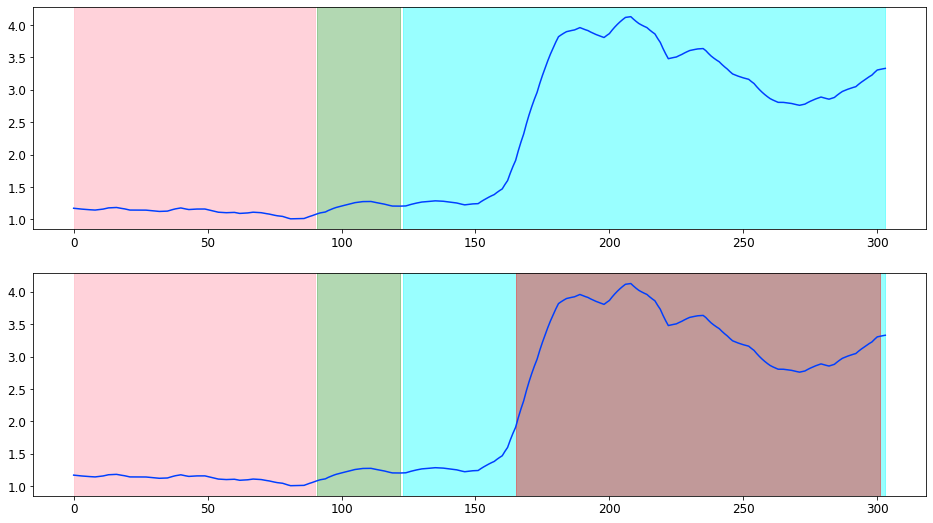

In [43]:
labels = pd.DataFrame(stats)['labels'][12]
idx_gesture = np.where(labels == 1)[0] + 60
df_for_plot = pd.DataFrame(stats)['df_to_plot'][12].reset_index(drop = True)

fig, ax = plt.subplots(2, figsize = (16, 9))
df_for_plot['kf4'].plot(ax = ax[0])
idx_st1 = df_for_plot[df_for_plot['trialState'] == 1].index
idx_st2 = df_for_plot[df_for_plot['trialState'] == 2].index
idx_st3 = df_for_plot[df_for_plot['trialState'] == 3].index
idx_st4 = df_for_plot[df_for_plot['trialState'] == 4].index
ax[0].axvspan(ymin = 0, ymax = 30, xmin = idx_st1[0], xmax = idx_st1[-1], alpha = 0.7, color = 'pink', label = 'TrialState1')
ax[0].axvspan(ymin = 0, ymax = 30, xmin = idx_st2[0], xmax = idx_st2[-1], alpha = 0.3, color = 'green', label = 'TrialState2')
ax[0].axvspan(ymin = 0, ymax = 30, xmin = idx_st3[0], xmax = idx_st3[-1], alpha = 0.4, color = 'cyan', label = 'TrialState3')

#################################

df_for_plot['kf4'].plot(ax = ax[1])
idx_st1 = df_for_plot[df_for_plot['trialState'] == 1].index
idx_st2 = df_for_plot[df_for_plot['trialState'] == 2].index
idx_st3 = df_for_plot[df_for_plot['trialState'] == 3].index
idx_st4 = df_for_plot[df_for_plot['trialState'] == 4].index
ax[1].axvspan(ymin = 0, ymax = 30, xmin = idx_st1[0], xmax = idx_st1[-1], alpha = 0.7, color = 'pink', label = 'TrialState1')
ax[1].axvspan(ymin = 0, ymax = 30, xmin = idx_st2[0], xmax = idx_st2[-1], alpha = 0.3, color = 'green', label = 'TrialState2')
ax[1].axvspan(ymin = 0, ymax = 30, xmin = idx_st3[0], xmax = idx_st3[-1], alpha = 0.4, color = 'cyan', label = 'TrialState3')
ax[1].axvspan(ymin = 0, ymax = 30, xmin = idx_gesture[0], xmax = idx_gesture[-1], alpha = 0.4, color = 'red', label = 'Gesture')


# Visualization of the trial that the model performed bad

The following trial is the one that model predicted all "Rest". We can see that compared to the previous plot, the EMG amplitude is relatively low even in trial state 3.

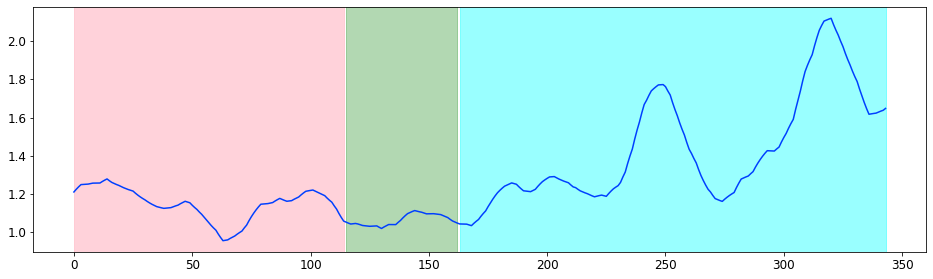

In [48]:
labels = pd.DataFrame(stats)['labels'][0]
fig, ax = plt.subplots(1, figsize = (16, 9/2))

df_for_plot = pd.DataFrame(stats)['df_to_plot'][0].reset_index(drop = True)

df_for_plot['kf4'].plot(ax = ax)
idx_st1 = df_for_plot[df_for_plot['trialState'] == 1].index
idx_st2 = df_for_plot[df_for_plot['trialState'] == 2].index
idx_st3 = df_for_plot[df_for_plot['trialState'] == 3].index
idx_st4 = df_for_plot[df_for_plot['trialState'] == 4].index
ax.axvspan(ymin = 0, ymax = 30, xmin = idx_st1[0], xmax = idx_st1[-1], alpha = 0.7, color = 'pink', label = 'TrialState1')
ax.axvspan(ymin = 0, ymax = 30, xmin = idx_st2[0], xmax = idx_st2[-1], alpha = 0.3, color = 'green', label = 'TrialState2')
ax.axvspan(ymin = 0, ymax = 30, xmin = idx_st3[0], xmax = idx_st3[-1], alpha = 0.4, color = 'cyan', label = 'TrialState3')
